In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
# REGRESSION_DSETS_LARGE_NAMES = data.REGRESSION_DSETS_LARGE_NAMES
import numpy.linalg as npl
from scipy.optimize import minimize
import style
%matplotlib inline
%load_ext autoreload
%autoreload 2

parent_dir = '/scratch/users/vision/yu_dl/raaz.rsk/mdl_sim_may/may14/'
save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)
folders = os.listdir(parent_dir)
print(folders)
# folders = [f for f in folders if 'may11' in f]

['clustered', 'iid', 'thresh', 't', 'gaussian_scale_var', 'decay']


# load results from a directory
**note - this script aggregates results - needs to be done to average across trials to make double descent curves**

In [2]:
# !rm /scratch/users/vision/yu_dl/raaz.rsk/mdl_sim_may/*/*processed*
# !python posptrocess.py

# figures

In [3]:
ls = '-'
LABS = {
    'mdl_m10.0': 'MDL-COMP',
    'ridge-1.0': 'Ridge-CV',
    'mdl_orig0.0': 'MDL-COMP-ORIG',
    'ols0.0': 'OLS'
}

**fig iid gaussian setting**

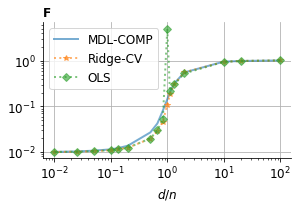

In [9]:
plot_all = False
folder = 'iid'
out_dir = oj(parent_dir, folder)
df = pd.read_pickle(oj(out_dir, 'processed.pkl')).reset_index()
df = df[df.model_type != 'mdl_orig'].reset_index()
df = df.iloc[df.model_type.str.slice(1).sort_values().index] # re-order so mdl comes first


plt.figure(figsize=(4.25, 3))
ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for i in range(df.shape[0]):
    curve = df.iloc[i]
    
    if curve.model_type == 'ridge' and curve.reg_param != -1:
        continue
        
    if 'ridge' in curve.model_type:
        ls = ':'
        mark = '*'
    elif 'ols' in curve.model_type:
        ls = ':'
        mark = 'D'
    elif 'mdl' in curve.model_type:
        ls = '-'
        mark = None
    
    kwargs = {'label': LABS[curve.model_type + str(curve.reg_param)],
              'alpha': 0.6, 'lw': 2, 'linestyle': ls, 'marker': mark}
    
    plt.title('F', fontweight='bold', loc='left')
    plt.plot(curve.ratio, curve.mse_test, **kwargs) #np.square(curve.bias) + curve['var'], **kwargs)
#     plt.ylabel('Test MSE')
    plt.xlabel('$d / n$') #\n(Number of features / Number of training points)')
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks([1e-2, 1e-1, 1e0, 1e1, 1e2])
    '''
    plt.subplot(R, C, 3)
    plt.title('C', fontweight='bold', loc='left')
    plt.plot(curve.ratio, curve.mse_train, **kwargs)
    plt.ylabel('Mean-squared error\n(training)')
    plt.xlabel('p / n')
    plt.xscale('log')
    plt.yscale('log')
    '''
    #     s = f'{model_type}_{dset}_{dset_name}+p={num_features}+lambda={reg_param}+noise_mult={noise_mult}'
plt.tight_layout()
# plt.xlim(right=1e5)
plt.grid()
ax = plt.gca()
# ax.xaxis.set_label_coords(0.3, -0.2)
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(0.98, 0.5), frameon=False)
plt.legend(frameon=True)
# plt.legend(bbox_to_anchor=(1.04 ,1), frameon=False)
# plt.tight_layout()
plt.savefig(oj(save_dir, 'fig_iid_mse.pdf'), bbox_inches = "tight")
plt.savefig(oj(save_dir, 'fig_iid_mse.svg'))
plt.show()

**fig shifts**

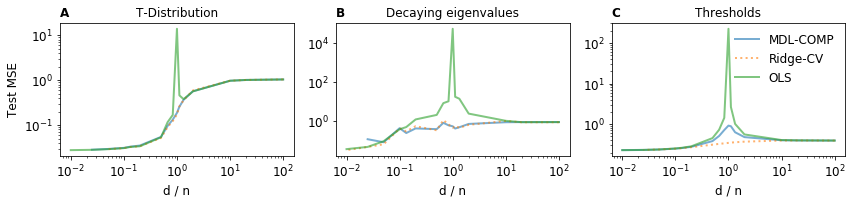

In [4]:
plot_all = False
R, C = 1, 3
lets = ['A', 'B', 'C', 'D', 'E']
titles = {
    't': 'T-Distribution',
    'thresh': 'Thresholds',
    'decay': 'Decaying eigenvalues'
}
plt.figure(figsize=(12, 3))
for j, folder in enumerate(['t', 'decay', 'thresh']): #, 'clustered', 'gaussian_scale_var']):
    plt.subplot(R, C, j + 1)
    plt.title(lets[j], fontweight='bold', loc='left')    
    out_dir = oj(parent_dir, folder)
    df = pd.read_pickle(oj(out_dir, 'processed.pkl')).reset_index()
    df = df[df.model_type != 'mdl_orig'].reset_index()
    df = df.iloc[df.model_type.str.slice(1).sort_values().index] # re-order so mdl comes first
    
#     plt.axhline(df.mse_zero.values[0], lw=4, color='gray', alpha=0.4, label='trivial')
    for i in range(df.shape[0]):
        curve = df.iloc[i]
    
        if 'ridge' in curve.model_type:
            ls = ':'
        elif 'ols' in curve.model_type:
            ls = '-'
        elif 'mdl' in curve.model_type:
            ls = '-'
        
        if curve.model_type == 'ridge' and curve.reg_param != -1:
            continue
        l = LABS[str(curve.model_type) + str(curve.reg_param)]
            

        kwargs = {'label': l, 'alpha': 0.6, 'lw': 2, 'linestyle': ls}

    #     plt.plot(curve.ratio, curve.mse_test, 
        plt.plot(curve.ratio, curve.mse_test, **kwargs) #np.square(curve.bias) + curve['var'], **kwargs)
    if j == 0:
        plt.ylabel('Test MSE')
    plt.xlabel('d / n') #\n(Number of features / Number of training points)')
    plt.xscale('log')
    plt.yscale('log')

#     s = f'{model_type}_{dset}_{dset_name}+p={num_features}+lambda={reg_param}+noise_mult={noise_mult}'
    if j == C - 1:
        plt.legend(frameon=False)
    
    plt.title(titles[folder])
plt.tight_layout()
plt.savefig(oj(save_dir, 'fig_shifts.pdf'))
plt.show()